<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Guide/Customization/Notebook1_Customization_EagerExecution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

    TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well. To follow along with this guide, run the code samples below in an interactive python interpreter.

    Eager execution is a flexible machine learning platform for research and experimentation, providing:

    An intuitive interface—Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
    Easier debugging—Call ops directly to inspect running models and test changes. Use standard Python debugging tools for immediate error reporting.
    Natural control flow—Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.
    Eager execution supports most TensorFlow operations and GPU acceleration.

In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import cProfile

1.15.0-rc3
CPU times: user 1.23 s, sys: 113 ms, total: 1.35 s
Wall time: 1.39 s


In [2]:
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.executing_eagerly())
if tf.config.experimental.list_physical_devices("GPU"):
    print("GPU is available.")

True
GPU is available.


In [0]:
x = [[2.]]
m = tf.matmul(x, x)

In [4]:
print(f"Hello {m}")

Hello [[4.]]


### Tensor to Numpy and Back

    Enabling eager execution changes how TensorFlow operations behave—now they immediately evaluate and return their values to Python. tf.Tensor objects reference concrete values instead of symbolic handles to nodes in a computational graph. Since there isn't a computational graph to build and run later in a session, it's easy to inspect results using print() or a debugger. Evaluating, printing, and checking tensor values does not break the flow for computing gradients.

    Eager execution works nicely with NumPy. NumPy operations accept tf.Tensor arguments. TensorFlow math operations convert Python objects and NumPy arrays to tf.Tensor objects. The tf.Tensor.numpy method returns the object's value as a NumPy ndarray.

In [0]:
import numpy as np

In [0]:
a = tf.random.uniform((2,2))
b = tf.add(a, 1)
print(a)
print(b)

tf.Tensor(
[[0.82237065 0.593189  ]
 [0.59490836 0.26099694]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.8223706 1.593189 ]
 [1.5949084 1.2609969]], shape=(2, 2), dtype=float32)


In [0]:
print(a*b)

tf.Tensor(
[[1.4986641  0.9450622 ]
 [0.9488243  0.32911634]], shape=(2, 2), dtype=float32)


In [0]:
c = np.multiply(a,b)

In [0]:
print(c)

[[1.4986641  0.9450622 ]
 [0.9488243  0.32911634]]


In [0]:
c.dtype

dtype('float32')

In [0]:
a.numpy()

array([[0.82237065, 0.593189  ],
       [0.59490836, 0.26099694]], dtype=float32)

In [0]:
a.dtype

tf.float32

In [0]:
b = tf.add(a, 1)

In [0]:
b.dtype

tf.float32

In [0]:
c = a*b

In [0]:
c.dtype

tf.float32

In [0]:
c = tf.multiply(a,b)
c.dtype

tf.float32

### Dynamic Control Flow

In [0]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num%3) == 0 and int(num % 5)==0:
            print("FizzBuzz")
        elif int(num%3)==0:
            print("Fizz")
        elif int(num%5) == 0:
            print("Buzz")
        else:
            print(num.numpy())
        counter += 1

In [0]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


### Eager Training

#### Computing Gradients

    Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks. During eager execution, use tf.GradientTape to trace operations for computing gradients later.

    You can use tf.GradientTape to train and/or compute gradients in eager. It is especially useful for complicated training loops.

    Since different operations can occur during each call, all forward-pass operations get recorded to a "tape". To compute the gradient, play the tape backwards and then discard. A particular tf.GradientTape can only compute one gradient; subsequent calls throw a runtime error.

In [0]:
w = tf.Variable(2.0)
with tf.GradientTape() as tape:
    loss = tf.multiply(w, w)
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor(4.0, shape=(), dtype=float32)


In [0]:
x = tf.cast(tf.constant(2), tf.float32)
w = tf.Variable(1, dtype=tf.float32)
b = tf.Variable(1, dtype=tf.float32)
with tf.GradientTape() as tape:
    a = 1 / (1+tf.exp(-(w*x+b)))
#grad_w = tape.gradient(a,w)
grad_b = tape.gradient(a,b)
#print(grad_w)
print(grad_b)

tf.Tensor(0.04517666, shape=(), dtype=float32)


#### Train a model

In [0]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Fetch and format the mnist data
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, [3,3],
                                                    activation="relu", input_shape=(None, None, 1)),
                             tf.keras.layers.Conv2D(16, [3,3], activation="relu"),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(10)
])

In [0]:
for images, labels in dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())

Logits:  [[-0.01847591  0.02100354 -0.0464275   0.0271399  -0.04827709  0.02196214
   0.00383322  0.01180129  0.04914055  0.03366013]]


In [0]:
optimizer = tf.keras.optimizers.Nadam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history = []

In [0]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [0]:
train()

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

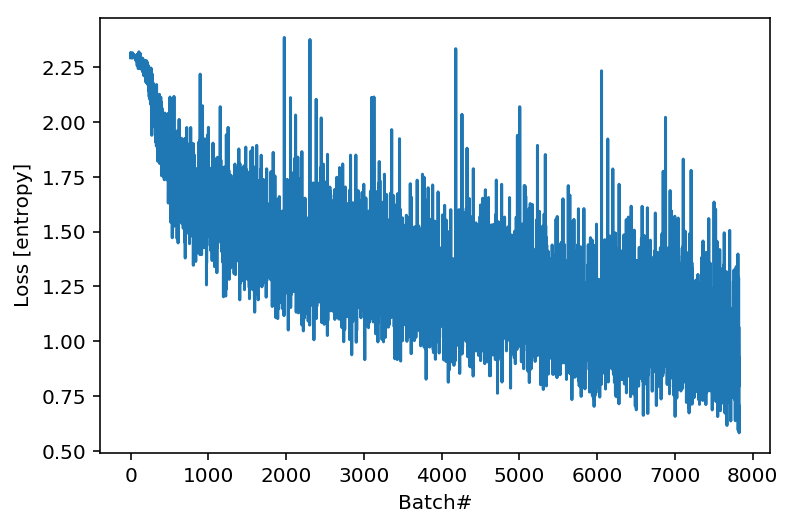

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.plot(loss_history)
plt.xlabel("Batch#")
plt.ylabel("Loss [entropy]")

#### Variables and Optimizers

* `tf.Variable` objects store mutable `tf.Tensor` values accessed during training to make automatic differentiation easier. The parameters of a model can be encapsulated in classes as variables.

* Better encapsulate model parameters by using `tf.Variable` with `tf.GradientTape`.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [0]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name="weight")
        self.B = tf.Variable(10., name="bias")
    def call(self, inputs):
        return inputs*self.W + self.B

In [0]:
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise 

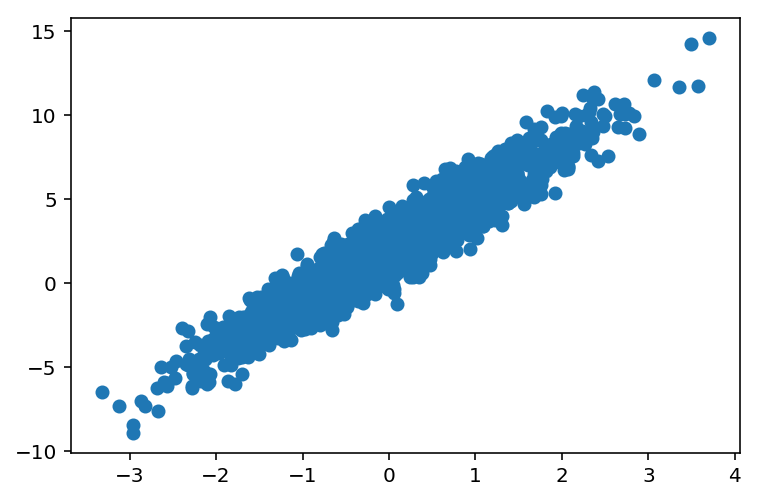

In [12]:
plt.scatter(training_inputs.numpy(), training_outputs.numpy())

In [0]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

In [33]:
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

print("Initial Loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Initial Loss: 67.961


In [34]:
for i in range(1000):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Loss at step 0: 67.695
Loss at step 20: 62.593
Loss at step 40: 57.882
Loss at step 60: 53.532
Loss at step 80: 49.514
Loss at step 100: 45.804
Loss at step 120: 42.378
Loss at step 140: 39.214
Loss at step 160: 36.292
Loss at step 180: 33.594
Loss at step 200: 31.102
Loss at step 220: 28.801
Loss at step 240: 26.676
Loss at step 260: 24.714
Loss at step 280: 22.902
Loss at step 300: 21.229
Loss at step 320: 19.683
Loss at step 340: 18.256
Loss at step 360: 16.939
Loss at step 380: 15.722
Loss at step 400: 14.598
Loss at step 420: 13.560
Loss at step 440: 12.602
Loss at step 460: 11.716
Loss at step 480: 10.899
Loss at step 500: 10.144
Loss at step 520: 9.447
Loss at step 540: 8.804
Loss at step 560: 8.209
Loss at step 580: 7.660
Loss at step 600: 7.153
Loss at step 620: 6.685
Loss at step 640: 6.253
Loss at step 660: 5.854
Loss at step 680: 5.485
Loss at step 700: 5.145
Loss at step 720: 4.830
Loss at step 740: 4.540
Loss at step 760: 4.272
Loss at step 780: 4.024
Loss at step 800: 3.

### Use objects for state during Eager Execution

With TF 1.x graph execution, program state (such as the variables) is stored in global collections and their lifetime is managed by the **`tf.Session`** object. In contrast, during eager execution the lifetime of state objects is determined by the lifetime of their corresponding Python object.

#### Variables are objects

During eager execution, variables persist until the last refence to the object is removed, and is then deleted.

In [41]:
if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("gpu:0"):
        print("GPU Enabled.")
        v = tf.Variable(tf.random.normal([1000,1000]))
        print(v)
        v = None
        print(v)

GPU Enabled.
<tf.Variable 'Variable:0' shape=(1000, 1000) dtype=float32, numpy=
array([[ 0.3255783 , -0.6169362 ,  0.43665835, ..., -1.0714504 ,
        -1.2599674 ,  1.1579587 ],
       [-0.05953751,  1.1687886 ,  0.5065513 , ..., -1.1292311 ,
        -0.45400357, -0.23305419],
       [ 0.9571142 ,  0.5325105 ,  1.0441504 , ..., -0.6537792 ,
        -0.9641364 ,  0.9732646 ],
       ...,
       [ 0.14705166, -0.27131662,  1.2570797 , ..., -0.7222952 ,
         1.5734929 , -1.331245  ],
       [-0.4067429 ,  0.9427616 , -0.4261187 , ...,  0.48473   ,
         1.6015052 , -0.3550602 ],
       [-0.0164848 , -0.6445583 , -0.28807586, ...,  0.41901675,
         1.2697902 ,  1.4744117 ]], dtype=float32)>
None


#### Object Based Saving

`tf.train.Checkpoint` can save and restore tf.Variables to and from checkpoints:



In [0]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [43]:
x.assign(2)
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [44]:
x.assign(11)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


To save and load models, tf.train.Checkpoint stores the internal state of objects, 
without requiring hidden variables. To record the state of a model, an optimizer, and a global step, pass them to a tf.train.Checkpoint:

In [46]:
import os
model = tf.keras.Sequential(
    [
     tf.keras.layers.Dense(10, activation="relu"),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1, activation=tf.nn.softmax)
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

root = tf.train.Checkpoint(optimizer = optimizer, model = model)
root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_prefix))

    Note: In many training loops, variables are created after tf.train.Checkpoint.restore is called. These variables will be restored as soon as they are created, and assertions are available to ensure that a checkpoint has been fully loaded. See the guide to training checkpoints for details.

#### Object Oriented Metrics

    tf.keras.metrics are stored as objects. Update a metric by passing the new data to the callable, and retrieve the result using the tf.keras.metrics.result method, for example:

In [53]:
mean = tf.keras.metrics.Mean(name="loss")
mean(0)
mean(5)
mean(10)
print(mean.result().numpy())

mean([8, 9])
print(mean.result().numpy())

5.0
6.4


#### Summaries and TensorBoard

TensorBoard is a visualization tool for understanding, debugging and optimizing the model training process. 

It uses summary events that are written while executing the program.

You can use tf.summary to record summaries of variable in eager execution. 
For example, to record summaries of loss once every 100 training steps:

In [0]:
# logdir = "./tb/"
# writer = tf.summary.create_file_writer(logdir)

# with writer.as_default():
#   for i in range(1000):
#     step = i + 1
#     # Calculate loss with your real train function.
#     loss = 1 - 0.001 * step
#     if step % 100 == 0:
#       tf.summary.scalar('loss', loss, step=step)

### Advanced automatic differentiation

#### Dynamic models

In [0]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = init_value
    while value > init_value - rate * grad_norm:
        x = init-x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

#### Custom Gradients

In [0]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [0]:
def log1exp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1exp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1exp(x)
    return tape.gradient(value, x)

In [6]:
grad_log1exp(tf.constant(0.)).numpy()

0.5

In [8]:
grad_log1exp(tf.constant(100.)).numpy()

nan

In [0]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

def grad_log1exp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [11]:
grad_log1exp(tf.constant(100.)).numpy()

1.0

In [12]:
grad_log1exp(tf.constant(0.)).numpy()

0.5

### Performance

Computation is automatically offloaded to GPUs during eager execution. If you want control over where a computation runs you can enclose it in a `tf.device('/gpu:0')` block (or the CPU equivalent):

In [16]:
import time 
def measure(x, steps):
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 1000
print("Time to multiply a {} matrix by itself {} times: ".format(shape, steps))

with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random.uniform(shape), steps)))
else :
    print("GPU: Not Found.!")

Time to multiply a (1000, 1000) matrix by itself 1000 times: 
CPU: 35.48453378677368 secs
GPU: 1.0357615947723389 secs


A `tf.Tensor` object can be copied to a different device to execute its operations:



In [0]:
if tf.config.experimental.list_physical_devices("GPU"):
    x = tf.random.normal([10, 10])
    x_gpu0 = x.gpu()
    x_cpu = x.cpu()
    _ = tf.matmul(x_cpu, x_cpu)
    _ = tf.matmul(x_gpu0, x_gpu0)

### Benchmarks 
    

For compute-heavy models, such as ResNet50 training on a GPU, eager execution performance is comparable to tf.function execution. But this gap grows larger for models with less computation and there is work to be done for optimizing hot code paths for models with lots of small operations.

### Work with functions

    While eager execution makes development and debugging more interactive, TensorFlow 1.x style graph execution has advantages for distributed training, performance optimizations, and production deployment. To bridge this gap, TensorFlow 2.0 introduces functions via the tf.function API. For more information, see the tf.function guide.